In [ ]:
!pip install datasets boto3 requests sentencepiece sacremoses tokenizers rank-bm25 faiss-gpu

     |████████████████████████████████| 163kB 14.0MB/s 
     |████████████████████████████████| 133kB 28.2MB/s 
     |████████████████████████████████| 1.1MB 43.3MB/s 
     |████████████████████████████████| 890kB 39.1MB/s 
     |████████████████████████████████| 2.9MB 44.7MB/s 
     |████████████████████████████████| 67.7MB 42kB/s 
     |████████████████████████████████| 245kB 55.5MB/s 
     |████████████████████████████████| 17.7MB 223kB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 7.2MB 42.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6655025b5b400786e670730222b649a1103d66f38c5c12bad4ab7bb49dc2e95e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.43 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
  

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!rsync -a --progress '/gdrive/My Drive/Deep Learning/Eksamensprojekt/trivia_qa_dataset_tok' '/content/'

sending incremental file list
trivia_qa_dataset_tok/
trivia_qa_dataset_tok/cache-d13f4619c823212a.arrow
  7,003,115,032 100%   20.48MB/s    0:05:26 (xfr#1, to-chk=2/4)
trivia_qa_dataset_tok/dataset_info.json
          3,958 100%    0.00kB/s    0:00:00 (xfr#2, to-chk=1/4)
trivia_qa_dataset_tok/state.json
            401 100%    2.33kB/s    0:00:00 (xfr#3, to-chk=0/4)


# Initialization

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from rank_bm25 import BM25Okapi
import time
from datasets import load_dataset, load_from_disk

In [ ]:
hugging_face_model = 'prajjwal1/bert-small'#'distilbert-base-uncased'#

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', hugging_face_model)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [ ]:
from tqdm import tqdm
from torch.cuda.amp.autocast_mode import autocast
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class BertModelCustom(torch.nn.Module):
  def __init__(self):
    super(BertModelCustom, self).__init__()
    self.model = torch.hub.load('huggingface/pytorch-transformers', 'model', hugging_face_model)
    self.linear1 = torch.nn.Linear(512, 512)
    self.linear2 = torch.nn.Linear(512, 512)
  def forward(self, q_p):
    embed = self.model(**q_p, output_hidden_states=True, return_dict=True)['hidden_states'][-1][:,0,:]
    #embed = torch.mean(self.model(**q_p, output_hidden_states=True, return_dict=True)['hidden_states'][-1],1)
    #embed = torch.mean(self.model(**q_p, output_hidden_states=True, return_dict=True)['hidden_states'][-2],1)
    embed = self.linear1(embed)
    embed = torch.nn.functional.gelu(embed)
    embed = self.linear2(embed)
    return embed

class BertModelAll(torch.nn.Module):
  def __init__(self):
    super(BertModelAll, self).__init__()
    self.model = torch.hub.load('huggingface/pytorch-transformers', 'model', hugging_face_model)
    self.linear1_p = torch.nn.Linear(512, 512)
    self.linear2_p = torch.nn.Linear(512, 512)

    self.linear1_q = torch.nn.Linear(512, 512)
    self.linear2_q = torch.nn.Linear(512, 512)
  def forward(self, q, p):
    #embed = torch.mean(self.model(**q_p, output_hidden_states=True, return_dict=True)['hidden_states'][-1],1)
    #embed = torch.mean(self.model(**q_p, output_hidden_states=True, return_dict=True)['hidden_states'][-2],1)
    #embed = self.model(**q_p, output_hidden_states=True, return_dict=True)['hidden_states']
    #attention_mask = q_p['attention_mask'].float()
    #embed = torch.einsum('bs,bsn->bsn',attention_mask,embed[-1]).sum(1)/attention_mask.sum(1)
    #^^^^^^^^^^^??????????? maybe just
    #embed = torch.mean(embed[-1][attention_mask])
    
    embed_q = self.embed_q(q)
    embed_p = self.embed_p(p)

    return embed_q, embed_p

  def embed_q(self, q):
    embed_q = self.model(**q, output_hidden_states=True, return_dict=True)['hidden_states'][-1][:,0,:]
    embed_q = self.linear1_q(embed_q)
    embed_q = torch.nn.functional.gelu(embed_q)
    embed_q = self.linear2_q(embed_q)
    return embed_q
  def embed_p(self,p):
    embed_p = self.model(**p, output_hidden_states=True, return_dict=True)['hidden_states'][-1][:,0,:]
    embed_p = self.linear1_p(embed_p)
    embed_p = torch.nn.functional.gelu(embed_p)
    embed_p = self.linear2_p(embed_p)
    return embed_p



modelname = "bert-small-512-shared"


# model_q = BertModelCustom()
# model_q.to(device)
# model_p = BertModelCustom()
# model_p.to(device)
# print("Trainable parameters:", sum(p.numel() for p in list(model_p.parameters())+list(model_q.parameters()) if p.requires_grad))
model_all = BertModelAll()
model_all.to(device)
print("Trainable parameters:", sum(p.numel() for p in model_all.parameters() if p.requires_grad))

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master



Trainable parameters: 29814272


# Dataloading and preparation for training loop
Run this section to load model and dataloader

In [ ]:
size = 126
stride = 32

def overlap_and_pad(input_ids, size=128, stride=64):
  extra = 0 if input_ids.size(0) < size else stride
  return F.pad(input=input_ids, pad=(0, size-(input_ids.size(0) % stride)-extra), mode='constant', value=0).unfold(0,size,stride)

def get_bm25_doc(sample):
  docs = tokenizer(" [SEP] ".join(sample['entity_pages']['wiki_context']), add_special_tokens=False, return_tensors='pt')['input_ids']
  docs = overlap_and_pad(docs[0], size=size, stride=stride).numpy()
  alias_query = tokenizer(sample['answer']['value'], add_special_tokens=False)['input_ids']
  bm25 = BM25Okapi(docs)
  doc_scores = bm25.get_scores(alias_query)
  max_idx = np.argmax(doc_scores)
  q = {}
  p = {}
  sample['q'] = tokenizer(sample['question'])['input_ids']
  sample['p'] = [tokenizer.cls_token_id] + docs[max_idx].tolist() + [tokenizer.sep_token_id]
  return sample

In [ ]:
dataset = load_from_disk('trivia_qa_dataset_tok')

#dataset = load_dataset("trivia_qa", 'rc', split='test')
#dataset.remove_columns_(['question_id', 'question_source', 'search_results'])
#dataset = dataset.filter(lambda x: len(x['entity_pages']['wiki_context']) > 0 and len(x['question']) > 0)
#dataset = dataset.map(get_bm25_doc)
#dataset.save_to_disk('/gdrive/My Drive/Deep Learning/Eksamensprojekt/trivia_qa_dataset_tok')

In [ ]:
dataset

Dataset({
    features: ['answer', 'entity_pages', 'p', 'q', 'question'],
    num_rows: 125112
})

In [ ]:
#from multiprocessing import cpu_count
def collate_fn(batch):
  q = {}
  q_special_tok = [torch.tensor(b['q']) for b in batch]
  q['input_ids'] = pad_sequence([q_tok[None,:].T for q_tok in q_special_tok], batch_first=True)[:,:,0]
  q['attention_mask'] = pad_sequence([torch.full_like(q_tok[None,:].T, 1) for q_tok in q_special_tok], batch_first=True)[:,:,0]
  
  p = {}
  p_special_tok = [torch.tensor(b['p']) for b in batch]
  p['input_ids'] = torch.stack(p_special_tok)
  p['attention_mask'] = torch.full_like(p['input_ids'], 1)
  return q, p

testloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=collate_fn, num_workers=4, pin_memory=True)#, worker_init_fn=worker_init_fn

NameError: ignored

In [ ]:
def loss_fn(e_q, e_p):
  #----------------v1.0----------------
  matrix = -torch.nn.LogSoftmax(1)(torch.mm(e_q,e_p.T))
  return torch.diag(matrix)

# def loss_fn(e_q, e_p):
#   #----------------v1.5----------------
#   matrix = torch.mm(e_q,e_p.T)
#   return -torch.diag(torch.nn.LogSoftmax(0)(matrix)), -torch.diag(torch.nn.LogSoftmax(1)(matrix))
  #----------------v2.0----------------
  #mask = torch.ones(matrix.shape, dtype=torch.bool).fill_diagonal_(0)
  #neg_sims = matrix[mask].expand(matrix.shape[0],mask.sum())
  #pos_sims = torch.diag(matrix)
  #return -torch.nn.LogSoftmax(1)(torch.cat([pos_sims.unsqueeze(1),neg_sims],1))[:,0], -torch.diag(torch.nn.LogSoftmax(0)(matrix)), -torch.diag(torch.nn.LogSoftmax(1)(matrix))

In [ ]:
from transformers import AdamW
from torch.cuda.amp.grad_scaler import GradScaler
scaler = GradScaler()
num_epochs = 20
no_decay = ['bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [{
#     'params': [p for n, p in list(model_q.named_parameters()) + list(model_p.named_parameters()) if not any(nd in n for nd in no_decay)],
#     'weight_decay': 0.01
# }, {
#     'params': [p for n, p in list(model_q.named_parameters()) + list(model_p.named_parameters()) if any(nd in n for nd in no_decay)],
#     'weight_decay': 0.0,
# }]
optimizer_grouped_parameters = [{
    'params': [p for n, p in model_all.named_parameters() if not any(nd in n for nd in no_decay)],
    'weight_decay': 0.01
}, {
    'params': [p for n, p in model_all.named_parameters() if any(nd in n for nd in no_decay)],
    'weight_decay': 0.0,
}]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, correct_bias=False) #, weight_decay=0.01
epoch = 0
losss = []

# Load training checkpoint
Run this section to load a model checkpoint

In [ ]:
import pickle
checkpoint = torch.load(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}/{modelname}.chkpt')
model_all.load_state_dict(checkpoint['all_state_dict'])
#model_p.load_state_dict(checkpoint['p_state_dict'])
#model_q.load_state_dict(checkpoint['q_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#with open(f"/gdrive/My Drive/Deep Learning/Eksamensprojekt/losses/{modelname}_loss.p","rb") as f:
#    losss = pickle.load(f)

<All keys matched successfully>

# Training Loop
Run this section to start training the loaded model

In [ ]:
from tqdm import tqdm
import pickle
while epoch < num_epochs:
  #model_p.train()
  #model_q.train()
  model_all.train()
  with tqdm(iter(testloader)) as tqdm_bar:
    for q, p in tqdm_bar:
      with autocast():
        p['input_ids'] = p['input_ids'].to(device)
        p['attention_mask'] = p['attention_mask'].to(device)
        q['input_ids'] = q['input_ids'].to(device)
        q['attention_mask'] = q['attention_mask'].to(device)
        
        # p_hid = model_p(p)
        # q_hid = model_q(q)

        q_hid, p_hid = model_all(q, p)
        loss = loss_fn(q_hid, p_hid).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
      losss.append(loss.detach().cpu().numpy())
      tqdm_bar.set_postfix_str(f"Loss: {losss[-1]:.3f}")
      #tqdm_bar.set_postfix_str(f"Loss: {losss[-1]:.3f}, loss_q: {loss_q.detach().mean().cpu().numpy():.3f}, loss_p: {loss_p.detach().mean().cpu().numpy():.3f}")
      #tqdm_bar.set_postfix_str(f"Loss: {losss[-1]:.3f}, loss_all: {loss_all.detach().mean().cpu().numpy():.3f}, loss_q: {loss_q.detach().mean().cpu().numpy():.3f}, loss_p: {loss_p.detach().mean().cpu().numpy():.3f}")
  epoch += 1
  torch.save({'epoch': epoch,'all_state_dict': model_all.state_dict()}, f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}.chkpt')
  #torch.save({'epoch': epoch,'p_state_dict': model_p.state_dict(), 'q_state_dict': model_q.state_dict()}, f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}.chkpt') #,'optimizer_state_dict': optimizer.state_dict()}
  with open(f"/gdrive/My Drive/Deep Learning/Eksamensprojekt/losses/{modelname}_loss.p","wb") as f:
    pickle.dump(losss, f)

100%|██████████| 1955/1955 [06:52<00:00,  4.74it/s, Loss: 0.001]


In [ ]:
def smooth(scalars, weight):
	last = scalars[0]
	smoothed = list()
	for point in scalars:
		smoothed_val = last * weight + (1 - weight) * point
		smoothed.append(smoothed_val)
		last = smoothed_val
	return smoothed

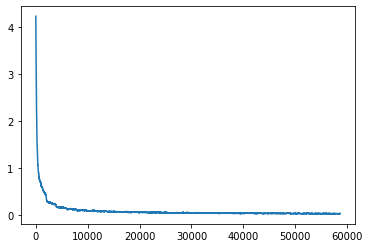

In [ ]:
from matplotlib import pyplot as plt
plt.plot(smooth(losss,0.99))

# Build Faiss Index

In [ ]:
import faiss
faiss_index_name = "IDMap,Flat"
#res = faiss.StandardGpuResources()
index = faiss.index_factory(512, faiss_index_name, faiss.METRIC_INNER_PRODUCT)
#gpu_index = faiss.index_cpu_to_gpu(res, 0, index)

#index = faiss.IndexHNSWFlat(128, 256, faiss.METRIC_INNER_PRODUCT) #512, 256, 128
#index.hnsw.efConstruction = 256
#index.hnsw.efSearch = 128
#index = faiss.IndexIDMap(index)

In [ ]:
doc_to_idx = dict()
idx_to_doc = dict()
doc_idx = 0

In [ ]:
from tqdm import tqdm
from time import time
#model_p.eval()
model_all.eval()
def add_faiss_index(batch):
  global doc_idx
  p_hids = []
  idxs = []
  for entity_page in batch['entity_pages']:
    for title, page in zip(entity_page['title'], entity_page['wiki_context']):
      if len(title) > 0 and len(page) > 0 and not title in doc_to_idx.keys():
        with torch.no_grad(), autocast():
          encoded_wiki = tokenizer(page, add_special_tokens=False, return_tensors='pt', return_token_type_ids=False)
          encoded_wiki = {k:overlap_and_pad(v[0], size=size, stride=stride).to(device) for k, v in encoded_wiki.items()}
          encoded_wiki = {k:torch.cat([
                                      torch.full((v.size(0),1), tokenizer.cls_token_id if k == 'input_ids' else 1, device=device, dtype=torch.int64), 
                                      v, 
                                      torch.full((v.size(0),1), tokenizer.sep_token_id if k == 'input_ids' else 1, device=device, dtype=torch.int64)
                                      ],1) for k, v in encoded_wiki.items()}
          encoded_wiki = {k:v.split(128) for k, v in encoded_wiki.items()}
          for input_ids, attention_mask in zip(*encoded_wiki.values()):
            p_hid = model_all.embed_p({'input_ids': input_ids, 'attention_mask': attention_mask}).float().cpu().numpy()
            #p_hid = model_p({'input_ids': input_ids, 'attention_mask': attention_mask}).float().cpu().numpy()
            p_hids.append(p_hid)
            idxs.append(np.full(p_hid.shape[0],doc_idx))
          doc_to_idx[title] = doc_idx
          idx_to_doc[doc_idx] = title
          doc_idx += 1
  if len(p_hids) > 0:
    index.add_with_ids(np.concatenate(p_hids,0), np.concatenate(idxs,0))

dataset_test = load_dataset("trivia_qa", 'rc', split='test')
dataset_test.map(add_faiss_index, new_fingerprint='uvutfkuyfkyf', batched=True, batch_size=16)

Dataset trivia_qa downloaded and prepared to /root/.cache/huggingface/datasets/trivia_qa/rc/1.1.0/e734e28133f4d9a353af322aa52b9f266f6f27cbf2f072690a1694e577546b0d. Subsequent calls will reuse this data.


Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 17210
})

In [ ]:
top_100_c_pred = []
model_all.eval()
#model_q.eval()
def search_faiss_index(batch):
  global top_100_c_pred
  used_questions = [question for entity_page, question in zip(batch['entity_pages'], batch['question']) if len(entity_page['wiki_context']) > 0 and len(entity_page['title']) > 0]
  used_idxs = [[doc_to_idx[title] for title in entity_page['title']] for entity_page in batch['entity_pages'] if len(entity_page['wiki_context']) > 0 and len(entity_page['title']) > 0]
  quest_embeds = []
  with torch.no_grad(), autocast():
    quest = tokenizer(used_questions, return_tensors='pt', padding=True, return_token_type_ids=False)
    quest = {k:v.to(device) for k, v in quest.items()}
    quest = {k:v.split(128) for k, v in quest.items()}
    for input_ids, attention_mask in zip(*quest.values()):
      quest_s = {'input_ids': input_ids, 'attention_mask': attention_mask}
      #quest_embeds.append(model_q(quest_s).float().cpu().numpy())
      quest_embeds.append(model_all.embed_q(quest_s).float().cpu().numpy())
    top_100_pred = index.search(np.concatenate(quest_embeds, 0), 100)[1]
  for pred, true_idxs in zip(top_100_pred, used_idxs):
    top_100_c_pred.append(np.isin(pred, true_idxs))

dataset_test.map(search_faiss_index, new_fingerprint='rtvgbtiy65vb', batched=True, batch_size=64)

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 17210
})

In [ ]:
top_100_c_pred_arr = np.array(top_100_c_pred)

In [ ]:
np.savez(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}_top_100_c_pred.npz', top_100_c_pred_arr)

In [ ]:
correct_doc_in_top_k = (top_100_c_pred_arr.cumsum(1) > 0).sum(0)/top_100_c_pred_arr.shape[0]

In [ ]:
correct_doc_in_top_k

array([0.5313646 , 0.61751271, 0.66480087, 0.69806344, 0.72180403,
       0.73904652, 0.75326514, 0.76458856, 0.77391752, 0.78170237,
       0.79000193, 0.79791546, 0.80364151, 0.80878852, 0.81457891,
       0.81895387, 0.82197774, 0.82513028, 0.82956958, 0.83201441,
       0.83490961, 0.83767612, 0.83999228, 0.84333784, 0.84513929,
       0.84764846, 0.85009329, 0.85324583, 0.85453259, 0.85639838,
       0.85774947, 0.85877887, 0.86083768, 0.86244612, 0.86405456,
       0.86643505, 0.8672071 , 0.86855819, 0.8695876 , 0.87119604,
       0.87254713, 0.87389822, 0.87499196, 0.87615004, 0.87705076,
       0.87820884, 0.87968861, 0.8810397 , 0.88181175, 0.88251946,
       0.88322718, 0.8846426 , 0.88541466, 0.88605803, 0.88663707,
       0.88740912, 0.88863154, 0.88940359, 0.89075468, 0.89165541,
       0.89217011, 0.89255613, 0.89294216, 0.89345686, 0.89442193,
       0.89519398, 0.89615904, 0.89648073, 0.89699543, 0.89776748,
       0.89866821, 0.89905424, 0.89931159, 0.89976195, 0.90027

Text(0, 0.5, 'Retrieved correct document in top-k (%)')

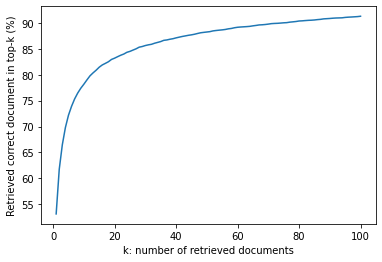

In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1,len(correct_doc_in_top_k)+1),correct_doc_in_top_k*100)
plt.xlabel("k: number of retrieved documents")
plt.ylabel("Retrieved correct document in top-k (%)")

In [ ]:
#index = faiss.index_gpu_to_cpu(gpu_index)
faiss.write_index(index, f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{faiss_index_name.replace(",","_")}_{modelname}.index')

In [ ]:
#index = faiss.read_index(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}/{faiss_index_name.replace(",","_")}_{modelname}.index')

# Inference

In [ ]:
def get_doc_from_idx(idx):
  found_doc = False
  doc = None
  for s in dataset_test:
    for doc,t in zip(s['entity_pages']['wiki_context'],s['entity_pages']['title']):
      if t == idx_to_doc[idx]:
        found_doc = True
        break
    if found_doc:
      break
  return doc


In [ ]:
question = 'When did World War I end?'
#model_q.eval()
#model_p.eval()
model_all.eval()
with torch.no_grad():
  quest = {k:v.to(device) for k, v in tokenizer(question, return_tensors='pt', padding=True).items()}
  quest_embed = model_all.embed_q(quest)
  #quest_embed = model_q(quest)
  top_docs = index.search(quest_embed.cpu().numpy(), 10)[1][0]
  for i, doc_idx in enumerate(top_docs):
    doc = get_doc_from_idx(doc_idx)
    top_k_idx = (top_docs == doc_idx).cumsum()[i]
    encoded_wiki = tokenizer(doc, add_special_tokens=False, return_tensors='pt', return_token_type_ids=False)
    encoded_wiki = {k:overlap_and_pad(v[0], size=size, stride=stride).to(device) for k, v in encoded_wiki.items()}
    encoded_wiki = {k:torch.cat([
                                torch.full((v.size(0),1), tokenizer.cls_token_id if k == 'input_ids' else 1, device=device, dtype=torch.int64), 
                                v, 
                                torch.full((v.size(0),1), tokenizer.sep_token_id if k == 'input_ids' else 1, device=device, dtype=torch.int64)
                                ],1) for k, v in encoded_wiki.items()}
    #p_hids = model_p(encoded_wiki)
    p_hids = model_all.embed_p(encoded_wiki)
    print(idx_to_doc[doc_idx], tokenizer.decode(encoded_wiki['input_ids'][torch.topk(torch.mm(p_hids,quest_embed.T).squeeze(),top_k_idx,0)[1][-1].cpu().numpy().item()]))

World War I [CLS] " their aggression. in the treaty of versailles, this statement was article 231. this article became known as war guilt clause as the majority of germans felt humiliated and resentful. overall the germans felt they had been unjustly dealt by what they called the " diktat of versailles. " schulze says, the treaty placed germany, " under legal sanctions, deprived of military power, economically ruined, and politically humiliated. " belgian historian laurence van ypersele emphasizes the central role played by memory of the war and the versailles treaty in german politics in the 1920s and 1930s : active denial of war guilt in germany and [SEP]
War [CLS] and other items of cultural significance is neither random nor irrelevant. preserving the world ’ s repositories of knowledge is crucial to ensuring that the darkest moments of history don't endlessly repeat themselves. " aims entities deliberately contemplating going to war and entities considering whether to end a war ma

# Reader-like inference

In [ ]:
question = 'When did world war I end?'
passage_embeds = []
passage_tokens = []
model_all.eval()
with torch.no_grad():
  quest = {k:v.to(device) for k, v in tokenizer(question, return_tensors='pt', padding=True).items()}
  quest_embed = model_all.embed_q(quest)
  top_doc = index.search(quest_embed.cpu().numpy(), 1)[1][0][0]
  doc = get_doc_from_idx(top_doc)
  for pas_len, pas_stride in tqdm(zip([1]+[i for i in range(2,32)],[1]+[i-1 for i in range(2,32)])):
    encoded_wiki = tokenizer(doc, add_special_tokens=False, return_tensors='pt', return_token_type_ids=False)
    encoded_wiki = {k:overlap_and_pad(v[0], size=pas_len, stride=pas_stride).to(device) for k, v in encoded_wiki.items()}
    encoded_wiki = {k:torch.cat([
                                torch.full((v.size(0),1), tokenizer.cls_token_id if k == 'input_ids' else 1, device=device, dtype=torch.int64), 
                                v, 
                                torch.full((v.size(0),1), tokenizer.sep_token_id if k == 'input_ids' else 1, device=device, dtype=torch.int64)
                                ],1) for k, v in encoded_wiki.items()}
    encoded_wiki = {k:v.split(512) for k, v in encoded_wiki.items()}
    for input_ids, attention_mask in zip(*encoded_wiki.values()):
      encoded_wiki_s = {'input_ids': input_ids, 'attention_mask': attention_mask}
      #quest_embeds.append(model_q(quest_s).float().cpu().numpy())
      passage_embeds.append(model_all.embed_p(encoded_wiki_s).float().cpu())
      for pas in input_ids.cpu():
        passage_tokens.append(pas)
passage_embeds = torch.cat(passage_embeds, 0)
topk = torch.topk(torch.matmul(passage_embeds,quest_embed.cpu().T).squeeze(),10)
for v, i in zip(topk.values.softmax(0),topk.indices):
  print(f"Prob: {v.item()*100:.2f}%, sentence: {tokenizer.decode(passage_tokens[i][1:-1])}")

31it [00:13,  2.25it/s]

Prob: 17.62%, sentence: end of world war
Prob: 14.15%, sentence: the war prevented
Prob: 10.53%, sentence: that resulted from world war i. before the end of
Prob: 8.56%, sentence: end the war
Prob: 8.50%, sentence: similarly affected. formal end of the war
Prob: 8.48%, sentence: end of the war
Prob: 8.40%, sentence: from world war i. before the end of the
Prob: 8.04%, sentence: end to the war
Prob: 8.01%, sentence: similarly affected. formal end of the war a
Prob: 7.71%, sentence: a result of world war


# Plot results

In [ ]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os.path
import pickle

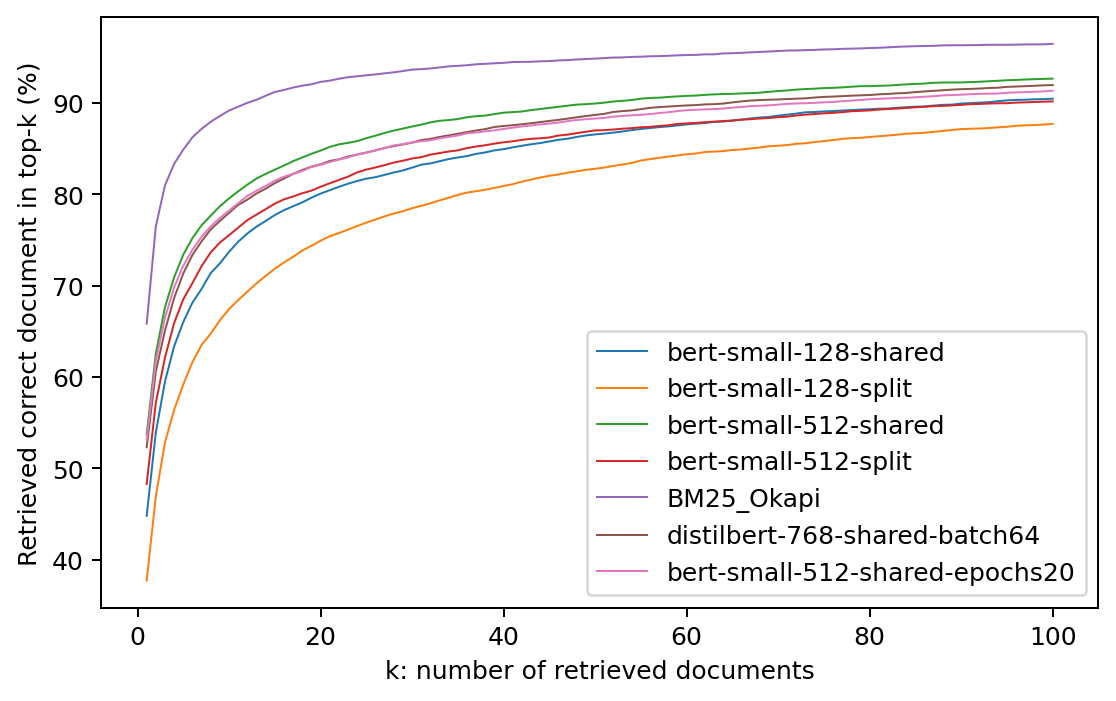

In [ ]:
plt.figure(figsize=(6.3,4), dpi=180)
legend = []
for f in glob('/gdrive/My Drive/Deep Learning/Eksamensprojekt/*/*.npz'):
  top_100_c_pred_arr = np.load(f)['arr_0']
  correct_doc_in_top_k = (top_100_c_pred_arr.cumsum(1) > 0).sum(0)/top_100_c_pred_arr.shape[0]
  legend.append(os.path.dirname(f).split("/")[-1].replace('-all','-shared'))
  plt.plot(np.arange(1,len(correct_doc_in_top_k)+1),correct_doc_in_top_k*100, linewidth=0.8)
plt.xlabel("k: number of retrieved documents")
plt.ylabel("Retrieved correct document in top-k (%)")
plt.legend(legend)
plt.tight_layout()
plt.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/accuracies.pdf',format="pdf",bbox_inches='tight',pad_inches=0)
plt.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/accuracies.png',format="png",bbox_inches='tight',pad_inches=0)

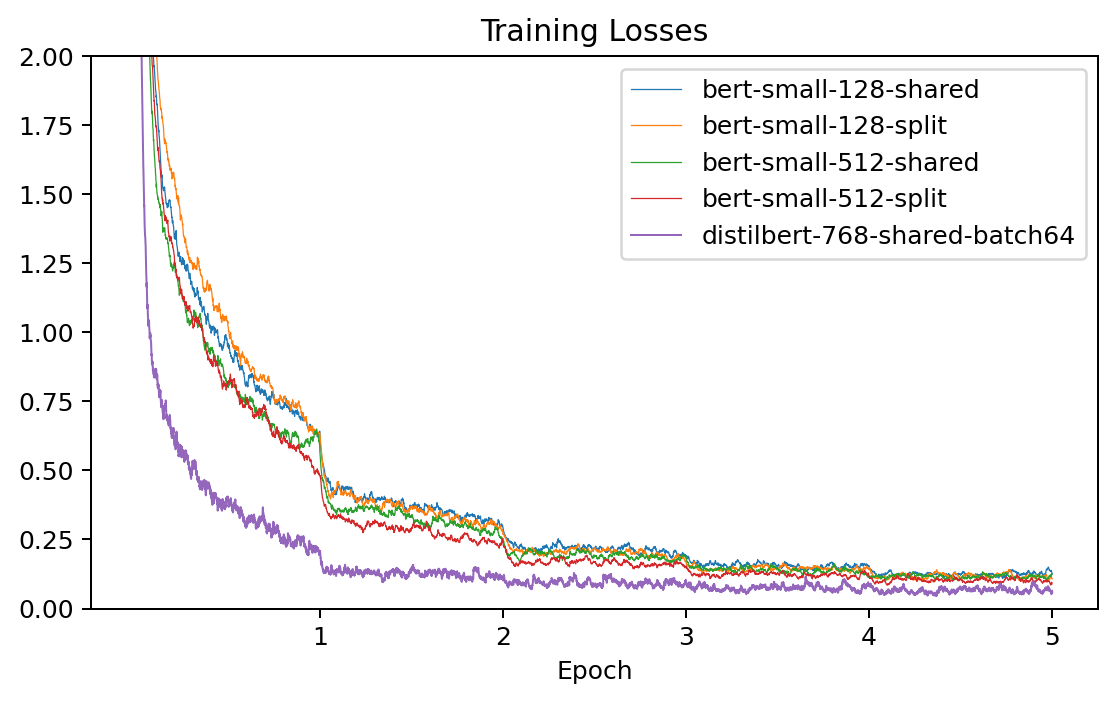

In [ ]:
def smooth(scalars, weight):
	last = scalars[0]
	smoothed = list()
	for point in scalars:
		smoothed_val = last * weight + (1 - weight) * point
		smoothed.append(smoothed_val)
		last = smoothed_val
	return smoothed
plt.figure(figsize=(6.3,4), dpi=180)
legend = []
for f in glob('/gdrive/My Drive/Deep Learning/Eksamensprojekt/*/*.npz'):
  m_name = os.path.dirname(f).split('/')[-1]
  loss_file = f"/gdrive/My Drive/Deep Learning/Eksamensprojekt/losses/{m_name}_loss.p"
  if os.path.exists(loss_file) and 'epochs20' not in m_name:
    with open(loss_file,"rb") as lf:
      losss = pickle.load(lf)
    legend.append(m_name.replace('-all','-shared'))
    if 'batch64' in m_name:
      plt.plot(np.linspace(1,4890,len(losss)),smooth(losss,0.95), linewidth=0.8)
    else:
      plt.plot(smooth(losss,0.95), linewidth=0.5)
plt.xticks(np.arange(1,6)*978, ['1','2','3','4','5'])
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylim([0,2])
plt.legend(legend)
plt.tight_layout()
plt.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/losses.pdf',format="pdf",bbox_inches='tight',pad_inches=0)
plt.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/losses.png',format="png",bbox_inches='tight',pad_inches=0)

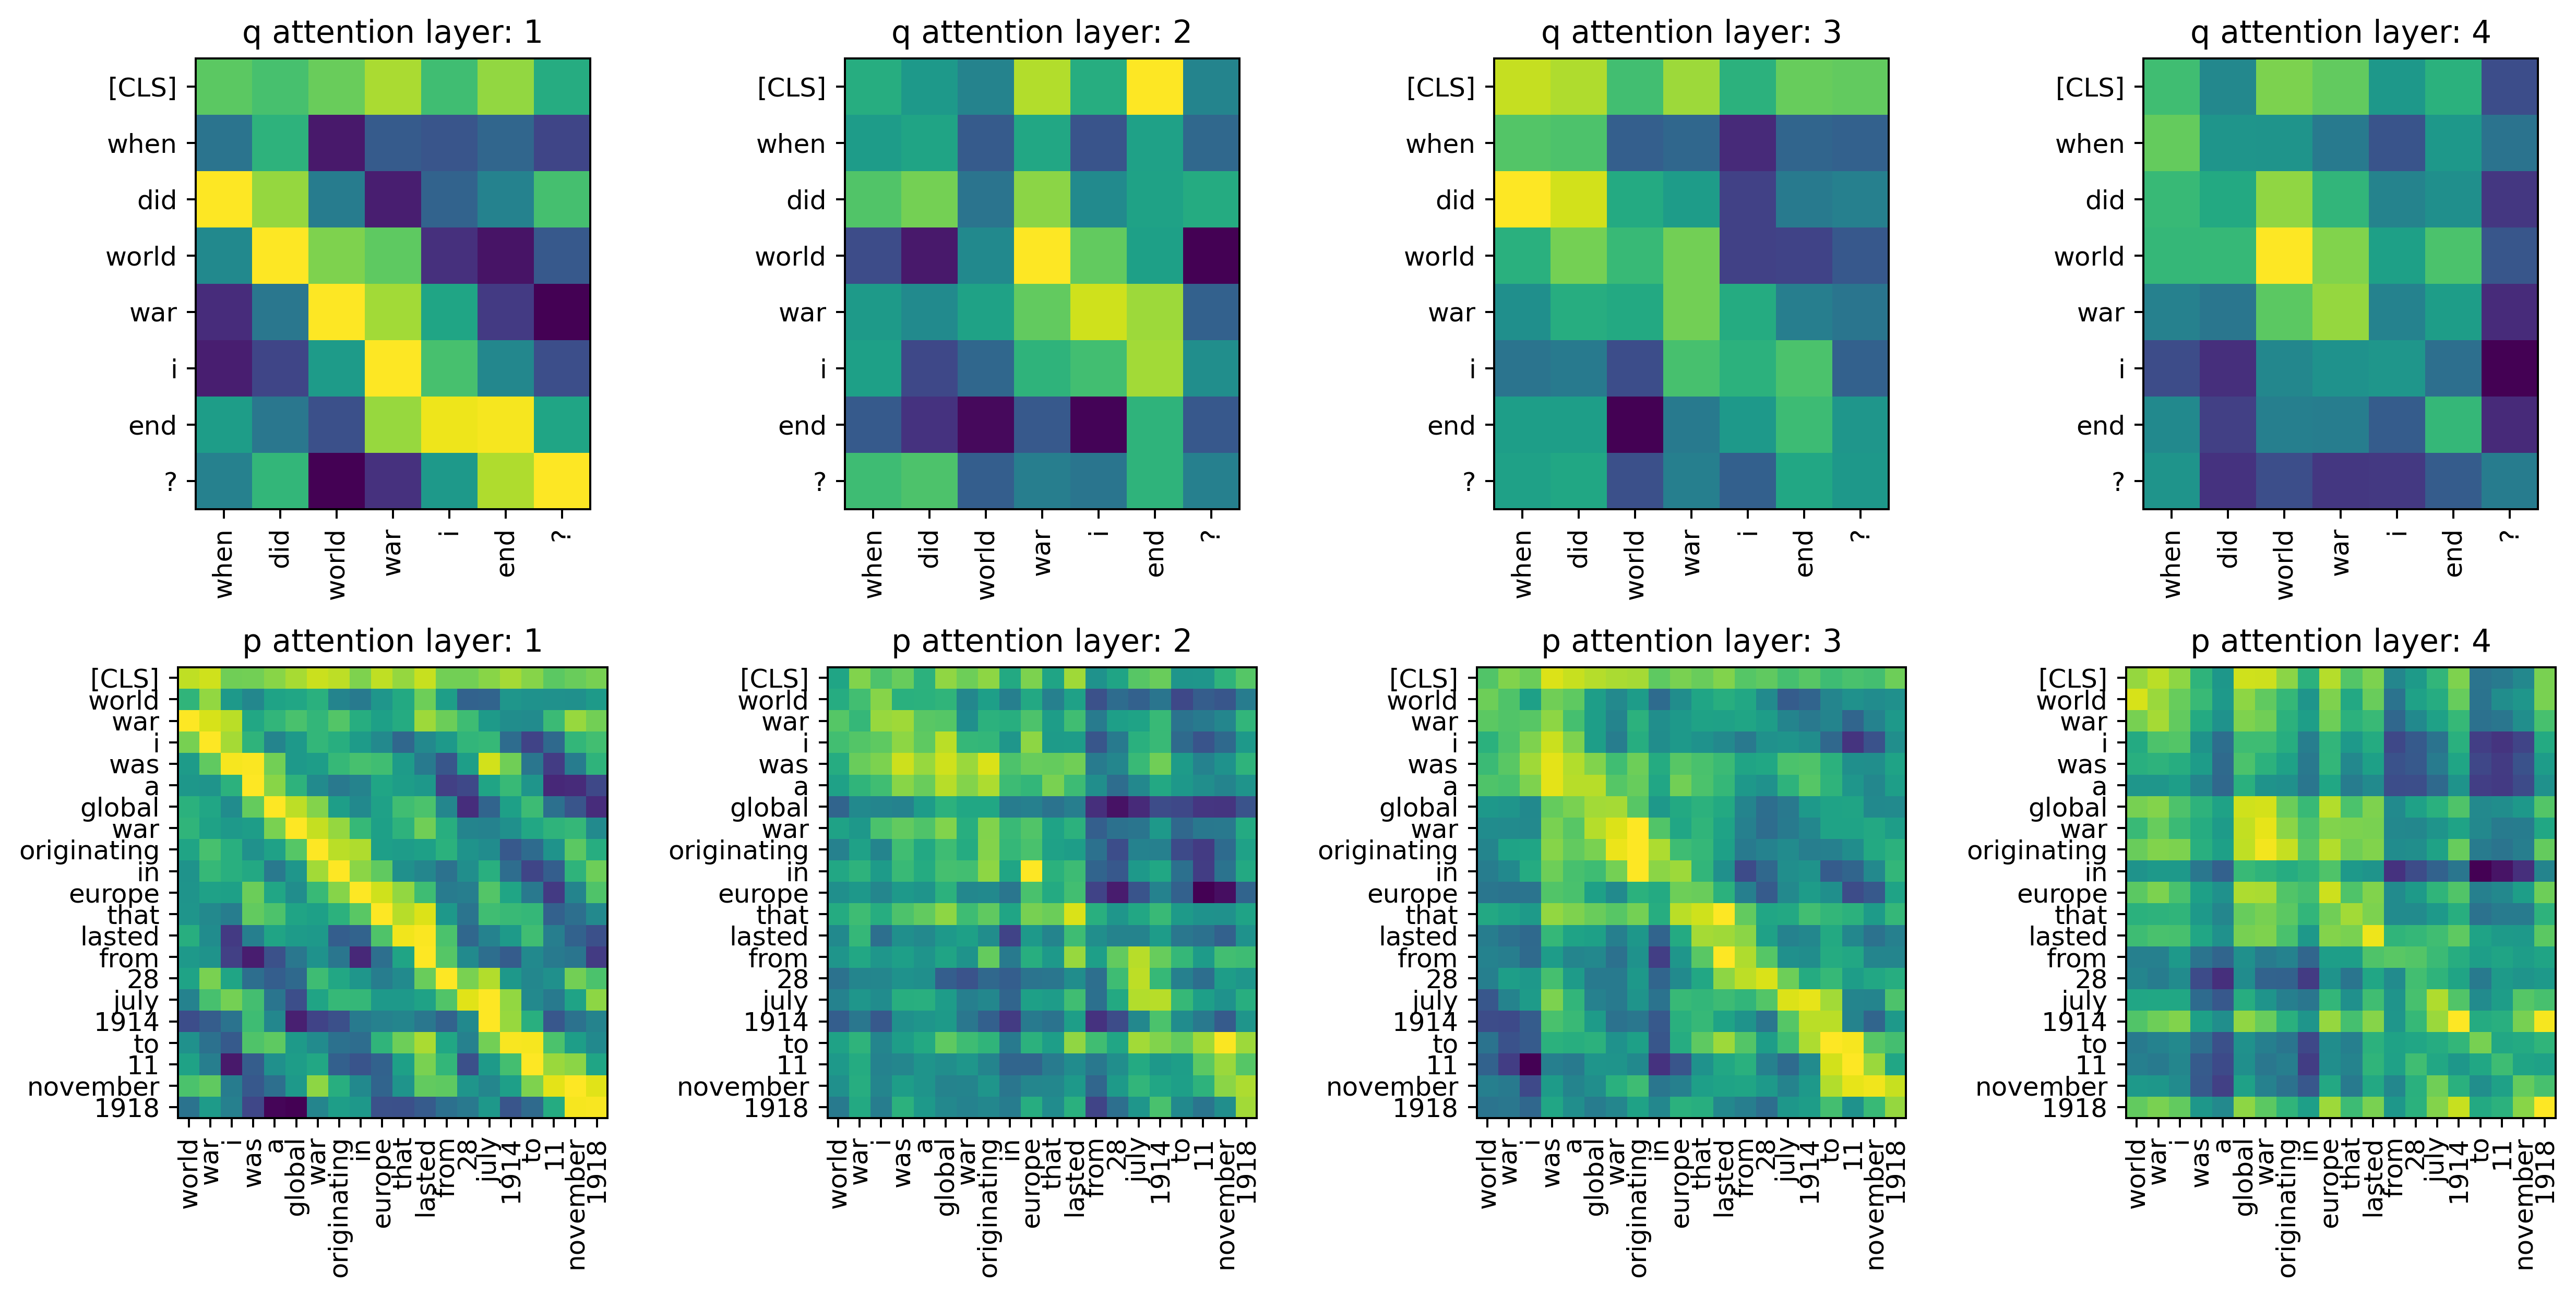

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(4*3.5,7), dpi=360)
for i in range(4):
  query_maps = []
  key_maps = []
  value_maps = []
  hooks = [
            model_all.model.encoder.layer[i].attention.self.query.register_forward_hook(
              lambda self, input, output: query_maps.append(output[0])
            ),
            model_all.model.encoder.layer[i].attention.self.key.register_forward_hook(
              lambda self, input, output: key_maps.append(output[0])
            ),
            model_all.model.encoder.layer[i].attention.self.value.register_forward_hook(
              lambda self, input, output: value_maps.append(output[0])
            )
  ]
  question = "When did World War I end?"
  passage = "World War I was a global war originating in Europe that lasted from 28 July 1914 to 11 November 1918"
  #question = "who was the head of the college of pontiffs?"
  #passage = "Until 104 BC, the pontifex maximus held the sole power in appointing members to the other priesthoods in the college."
  model_all.eval()
  with torch.no_grad():
    quest = {k:v.to(device) for k, v in tokenizer(question, return_tensors='pt', padding=True).items()}
    quest_embed = model_all.embed_q(quest)
    pas = {k:v.to(device) for k, v in tokenizer(passage, return_tensors='pt', padding=True).items()}
    pas_embed = model_all.embed_p(pas)
  for hook in hooks:
    hook.remove()

  attn_maps = []
  attn_toks = []
  for query_layer, key_layer, value_layer, pqs in zip(query_maps, key_maps, value_maps, [quest, pas]):
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    #attention_scores = torch.matmul(query_layer[:,64*5:64*(5+1)], key_layer[:,64*5:64*(5+1)].transpose(-1, -2)) # LOOK AT ONE HEAD ONLY
    attention_scores = attention_scores / np.sqrt(model_all.model.encoder.layer[-1].attention.self.attention_head_size)
    attention_probs = torch.nn.LogSoftmax(dim=-1)(attention_scores)
    attn_maps.append(attention_probs)
    attn_toks.append([tokenizer.decode(pq) for pq in pqs['input_ids'][0]])


  for attn_map, attn_tok, ax, ttl in zip(attn_maps, attn_toks, [axs[0][i], axs[1][i]], ['q attention layer: ', 'p attention layer: ']):
    ax.imshow(attn_map.cpu()[:-1,1:-1], interpolation='none', aspect='equal', cmap='viridis')
    ax.set_xticks(np.arange(len(attn_tok[1:-1])))
    ax.set_yticks(np.arange(len(attn_tok[:-1])))
    ax.set_xticklabels(attn_tok[1:-1])
    ax.set_yticklabels(attn_tok[:-1])
    ax.set_title(ttl+str(i+1))
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.tight_layout()
# fig.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}_self_attentions_ALL_LAYERS_pontiff.pdf',
#              format="pdf",
#              bbox_inches='tight',
#              pad_inches=0)
# fig.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}_self_attentions_ALL_LAYERS_pontiff.png',
#              format="png",
#              bbox_inches='tight',
#              pad_inches=0)

In [ ]:
query_layer[:,:64]

tensor([[-2.2025,  0.4418,  0.3726,  ..., -0.7212,  0.1160,  0.5523],
        [-3.1494, -0.4508,  0.9805,  ...,  0.3398, -0.3644, -0.1086],
        [-2.6463, -0.0583,  1.0584,  ...,  0.2056, -0.1747, -0.2676],
        ...,
        [-3.1354, -0.0557,  0.6362,  ...,  0.0258, -0.1447, -0.4868],
        [-1.5238,  0.1380,  0.9690,  ..., -1.2341, -0.6492, -0.2202],
        [-0.2763,  0.4506,  0.6876,  ...,  0.1610, -0.3168,  0.4527]],
       device='cuda:0')

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(8,4), dpi=360)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6dc8fc85f8>,
      dtype=object)

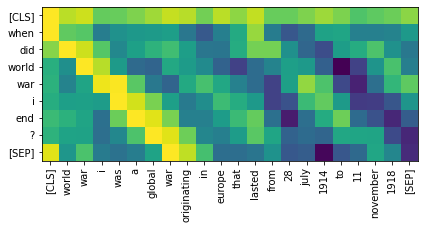

In [ ]:
query_maps = []
key_maps = []
value_maps = []
hooks = [
          model_all.model.encoder.layer[0].attention.self.query.register_forward_hook(
            lambda self, input, output: query_maps.append(output[0])
          ),
          model_all.model.encoder.layer[0].attention.self.key.register_forward_hook(
            lambda self, input, output: key_maps.append(output[0])
          ),
          model_all.model.encoder.layer[0].attention.self.value.register_forward_hook(
            lambda self, input, output: value_maps.append(output[0])
          )
]
question = "When did World War I end?"
passage = "World War I was a global war originating in Europe that lasted from 28 July 1914 to 11 November 1918"
model_all.eval()
with torch.no_grad():
  quest = {k:v.to(device) for k, v in tokenizer(question, return_tensors='pt', padding=True).items()}
  quest_embed = model_all.embed_q(quest)
  pas = {k:v.to(device) for k, v in tokenizer(passage, return_tensors='pt', padding=True).items()}
  pas_embed = model_all.embed_p(pas)
for hook in hooks:
  hook.remove()

attn_maps = []
attn_toks = []
attention_scores = torch.matmul(query_maps[0], key_maps[1].transpose(-1, -2))
attention_scores = attention_scores / np.sqrt(model_all.model.encoder.layer[-1].attention.self.attention_head_size)
attention_probs = torch.nn.LogSoftmax(dim=-1)(attention_scores)
attn_map = attention_probs


plt.imshow(attn_map.cpu(), interpolation='none', aspect='equal', cmap='viridis')
plt.xticks(np.arange(len([tokenizer.decode(pq) for pq in pas['input_ids'][0]])), [tokenizer.decode(pq) for pq in pas['input_ids'][0]], rotation=90)
plt.yticks(np.arange(len([tokenizer.decode(pq) for pq in quest['input_ids'][0]])), [tokenizer.decode(pq) for pq in quest['input_ids'][0]])
plt.tight_layout()
# fig.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}_self_attentions.pdf',
#              format="pdf",
#              bbox_inches='tight',
#              pad_inches=0)
# fig.savefig(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/{modelname}_self_attentions.png',
#              format="png",
#              bbox_inches='tight',
#              pad_inches=0)

# BM25 Okapi

In [ ]:
doc_to_idx = dict()
idx_to_doc = dict()
corpus = []
doc_idx = 0
def add_bm25_corpus(batch):
  global doc_idx, corpus
  p_hids = []
  for entity_page in batch['entity_pages']:
    for title, page in zip(entity_page['title'], entity_page['wiki_context']):
      if len(title) > 0 and len(page) > 0 and not title in doc_to_idx.keys():
        encoded_wiki = tokenizer(page, add_special_tokens=False, return_token_type_ids=False, return_attention_mask=False)
        corpus.append(encoded_wiki['input_ids'])
        doc_to_idx[title] = doc_idx
        idx_to_doc[doc_idx] = title
        doc_idx += 1

dataset_test = load_dataset("trivia_qa", 'rc', split='test')
dataset_test.map(add_bm25_corpus, new_fingerprint='4v3gyy34tc43', batched=True, batch_size=16)

Reusing dataset trivia_qa (/root/.cache/huggingface/datasets/trivia_qa/rc/1.1.0/e734e28133f4d9a353af322aa52b9f266f6f27cbf2f072690a1694e577546b0d)


Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 17210
})

In [ ]:
bm25 = BM25Okapi(corpus)

In [ ]:
top_100_c_pred = []
def search_bm25_corpus(batch):
  global top_100_c_pred
  used_questions = [question for entity_page, question in zip(batch['entity_pages'], batch['question']) if len(entity_page['wiki_context']) > 0 and len(entity_page['title']) > 0]
  used_idxs = [[doc_to_idx[title] for title in entity_page['title']] for entity_page in batch['entity_pages'] if len(entity_page['wiki_context']) > 0 and len(entity_page['title']) > 0]
  quest = tokenizer(used_questions, add_special_tokens=False, return_token_type_ids=False, return_attention_mask=False)['input_ids']
  for q, true_idxs in zip(quest, used_idxs):
    scores = bm25.get_scores(q)
    top_k_scores = scores.argsort()[-100:][::-1]
    top_100_c_pred.append(np.isin(top_k_scores, true_idxs))

dataset_test.map(search_bm25_corpus, new_fingerprint='rtvgbtiy65vb', batched=True, batch_size=64)

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 17210
})

In [ ]:
top_100_c_pred_arr = np.array(top_100_c_pred)
np.savez(f'/gdrive/My Drive/Deep Learning/Eksamensprojekt/BM25_Okapi_top_100_c_pred.npz', top_100_c_pred_arr)
correct_doc_in_top_k = (top_100_c_pred_arr.cumsum(1) > 0).sum(0)/top_100_c_pred_arr.shape[0]

Text(0, 0.5, 'Retrieved correct document in top-k (%)')

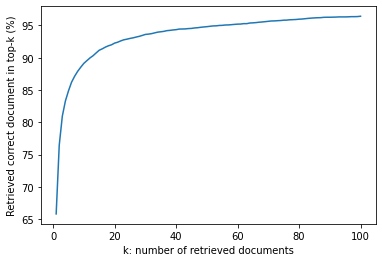

In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1,len(correct_doc_in_top_k)+1),correct_doc_in_top_k*100)
plt.xlabel("k: number of retrieved documents")
plt.ylabel("Retrieved correct document in top-k (%)")

In [ ]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import os.path
import pickle
accurs = []
for f in glob('/gdrive/My Drive/Deep Learning/Eksamensprojekt/*/*.npz'):
  top_100_c_pred_arr = np.load(f)['arr_0']
  correct_doc_in_top_k = (top_100_c_pred_arr.cumsum(1) > 0)
  accurs.append((os.path.dirname(f).split("/")[-1].replace('-all','-shared'), correct_doc_in_top_k))

In [ ]:
accurs[0][1].shape

(15543, 100)

In [ ]:
for n, a in accurs:
  std = 1.96*np.sqrt(a.var(axis=0)/a.shape[0])
  cfs = np.stack([a.mean(axis=0)]).T
  print(f"{n} & "+" & ".join([f"{100*(cfs[cf-1][0]):.2f}\\%" for cf in [1,5,20,50,100]])+"\\\\")

bert-small-128-split & 37.73\% & 59.18\% & 74.90\% & 82.76\% & 87.67\%\\
bert-small-512-split & 48.30\% & 68.49\% & 80.80\% & 86.95\% & 90.13\%\\
BM25_Okapi & 65.82\% & 84.86\% & 92.26\% & 94.81\% & 96.42\%\\
distilbert-768-shared-batch64 & 52.32\% & 71.31\% & 83.25\% & 88.65\% & 91.91\%\\
bert-small-512-shared-epochs20 & 53.14\% & 72.18\% & 83.20\% & 88.25\% & 91.30\%\\
bert-small-512-shared & 53.71\% & 73.37\% & 84.75\% & 89.90\% & 92.62\%\\
bert-small-128-shared & 44.82\% & 66.01\% & 80.05\% & 86.52\% & 90.43\%\\
